In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# AutoRegressive Model

> Step-by-step guide on using the `AutoRegressive Model` with `Statsforecast`.


During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

The text in this article is largely taken from:
1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). “Models for optimising the theta method and their relationship to state space models”. International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243).
3. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html)

## Table of Contents

* [Introduction](#introduction)
* [Autoregressive Models](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of AutoRegressive with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

The `autoregressive` time series model `(AutoRegressive)` is a `statistical` technique used to analyze and predict univariate time series. In essence, the `autoregressive model` is based on the idea that previous values of the time series can be used to predict future values.

In this model, the dependent variable (the time series) returns to itself at different moments in time, creating a dependency relationship between past and present values. The idea is that past values can help us understand and predict future values of the series.

The `autoregressive model` can be fitted to different orders, which indicate how many past values are used to predict the present value. For example, an `autoregressive model` of order 1 $(AR(1))$ uses only the immediately previous value to predict the current value, while an `autoregressive model` of order $p (AR(p))$ uses the $p$ previous values.

The `autoregressive model` is one of the basic models of time series analysis and is widely used in a variety of fields, from finance and economics to meteorology and social sciences. The model's ability to capture nonlinear dependencies in time series data makes it especially useful for forecasting and long-term trend analysis.

In a `multiple regression model`, we forecast the variable of interest using a linear combination of predictors. In an `autoregression model`, we forecast the variable of interest using a `linear combination` of past values of the variable. The term `autoregression` indicates that it is a regression of the variable against itself.

## Definition of Autoregressive Models <a class="anchor" id="model"></a>

Before giving a formal definition of the ARCH model, let's define the components of an ARCH model in a general way:

* Autoregressive, a concept that we have already known, is the construction of a univariate time series model using statistical methods, which means that the current value of a variable is influenced by past values of itself in different periods.
* Heteroscedasticity means that the model can have different magnitudes or variability at different time points (variance changes over time).
* Conditional, since volatility is not fixed, the reference here is the constant that we put in the model to limit heteroscedasticity and make it conditionally dependent on the previous value or values of the variable.

The AR model is the most basic building block of univariate time series. As you have seen before, univariate time series are a family of models that use only information about the target variable's past to forecast its future, and do not rely on other explanatory variables.
 
**Definition 1.** (1) The following equation is called the autoregressive model of order $p$ and denoted by $\text{AR(p)}$:

$$
\begin{equation}
Xt =\varphi_0 +\varphi_1X_{t−1}+\varphi_2X_{t−2}+\cdots+\varphi_p X_{t−p}+\varepsilon_t  \tag 1
\end{equation}
$$

where $\{\varepsilon_t \} \sim WN(0,\sigma_{\epsilon}^2)$, $E(X_s \varepsilon_t) = 0$ if $s < t$ and $\varphi_0,\varphi_1,\cdots ,\varphi_p$ are real-valued parameters (coefficients) with $\varphi_p \neq 0$. 

(2) If a time series $\{X_t \}$ is stationary and satisfies such an equation as (1), then we call it an $\text{AR(p)}$ process.

Note the following remarks about this definition:

* For simplicity, we often assume that the intercept (const term) $\varphi_0 = 0$; otherwise, we can consider $\{X_t −\mu \}$ where $\mu =\varphi_0 /(1−\varphi_1 − \cdots −\varphi_p)$.

* We distinguish the concept of $\text{AR}$ models from the concept of $\text{AR}$ processes. $\text{AR}$ models may or may not be stationary and $\text{AR}$ processes must be stationary.

* $E(X_s \varepsilon_t) = 0(s < t)$ means that $X_s$ in the past has nothing to do with $\varepsilon_t$ at the current time $t$.

* Like the definition of MA models, sometimes εt in Eq.(1) is called the innovation or shock term.

In addition, using the backshift([see](https://otexts.com/fpp3/backshift.html)) operator $B$, the $\text{AR(p)}$ model can be rewritten as

$$\varphi(B)X_t = \varepsilon_t$$

where $\varphi(z) = 1 − \varphi_1z − \cdots − \varphi_p z^p$ is called the (corresponding) $\text{AR}$ polynomial. Besides, in the Python package |StatsModels|, $\varphi(B)$ is called the $\text{AR}$ lag polynomial.

### Definition of PACF

Let $\{X_t \}$ be a stationary time series with $E(X_t) = 0$. Here the assumption $E(X_t ) = 0$ is for conciseness only. If $E(X_t) = \mu \neq 0$, it is okay to replace $\{X_t \}$ by $\{X_t − \mu \}$. Now consider the linear regression (prediction) of $X_t$ on $\{X_{t−k+1:t−1} \}$ for any integer $k ≥ 2$. We use $\hat X_t$ to denote this regression (prediction):

$$\hat X_t =\alpha_1 X_{t−1}+ \cdots +\alpha_{k−1} X_{t−k+1}$$

where $\{\alpha_1, \cdots , \alpha_{k−1} \}$ satisfy

$$\{\alpha_1, \cdots , \alpha_{k−1} \}=\argmin_{β1,···,βk−1} E[X_t −(\beta_1 X_{t−1} +\cdots +\beta_{k−1}X_{t−k+1})]^2$$

That is, $\{\alpha_1, \cdots , \alpha_{k−1} \}$ are chosen by minimizing the mean squared error of prediction. Similarly, let $\hat X_{t −k}$ denote the regression (prediction) of $X_{t −k}$ on $\{X_{t −k+1:t −1} \}$:

$$\hat X_{t−k} =\eta_1 X_{t−1}+ \cdots +\eta_{k−1} X_{t−k+1}$$

Note that if $\{X_t \}$ is stationary, then $\{ \alpha_{1:k−1}\} = \{\eta_{1:k−1} \}$. Now let $\hat Z_{t−k} = X_{t−k} − \hat X_{t−k}$ and $\hat Z_t = X_t − \hat X_t$. Then $\hat Z_{t−k}$ is the residual of removing the effect of the intervening variables $\{X_{t−k+1:t−1} \}$ from $X_{t−k}$, and $\hat Z_t$ is the residual of removing the effect of $\{X_{t −k+1:t −1} \}$ from $X_t$.

**Definition 2.** The partial autocorrelation function(PACF) at lag $k$ of astationary time series $\{X_t \}$ with $E(X_t ) = 0$ is

$$\phi_{11} = Corr(X_{t−1}, X_t ) = \frac{Cov(X_{t−1}, X_t )} {[Var(X_{t−1})Var(X_t)]^1/2}=\rho_1$$

and 

$$\phi_{kk} = Corr(\hat Z_{t−k},\hat Z_t)=\frac{Cov(\hat Z_{t−k},\hat Z_t)} {[Var(\hat Z_{t−k})Var(\hat Z_t)]^{1/2}}$$

According to the property of correlation coefficient (see, e.g., P172, Casella and Berger 2002), |φkk| ≤ 1. On the other hand, the following theorem paves the way to estimate the PACF of a stationary time series, and its proof can be seen in Fan and Yao (2003).

 On the other hand, the following theorem paves the way to estimate the PACF of a stationary time series, and its proof can be seen in Fan and Yao (2003).

 **Theorem 1.** Let $\{X_t \}$ be a stationary time series with $E(X_t) = 0$, and $\{a_{1k},\cdots ,a_{kk} \}$ satisfy

 $$\{a_{1k},\cdots,a_{kk} \}=\argmin_{a_1 ,\cdots ,a_k} E(X_{t −a1}X_{t−1}−\cdots −a_k X_{t−k})^2$$

 Then $\phi_{kk}=a_{kk}$ for $k≥1$.

### Properties of Autoregressive Models

From the $\text{AR(p)}$ model, namely, Eq. (1), we can see that it is in the same form as the multiple linear regression model. However, it explains current itself with its own past. Given the past

$$\{X_{(t−p):(t−1)} \} = \{x_{(t−p):(t−1)} \}$$

we have
$$E(X_t |X_{(t−p):(t−1)}) = \varphi_0 + \varphi_1x_{t−1} + \varphi_2 x_{t−2} + \cdots + \varphi_p x_{t−p}$$

This suggests that given the past, the right-hand side of this equation is a good estimate of $X_t$ . Besides

$$Var(X_t |X_{(t −p):(t −1)}) = Var(\varepsilon_t ) = \sigma_{\varepsilon}^2$$

Now we suppose that the AR(p) model, namely, Eq. (1), is stationary; then we have

1. The model mean $E(_Xt)=\mu =\varphi_0 / (1−\varphi_1−···−\varphi_p)$ .Thus,themodelmean $\mu=0$ if and only if $\varphi_0 =0$.

2. If the mean is zero or $\varphi_0 = 0$ ((3) and (4) below have the same assumption), noting that $E(X_t \varepsilon_t ) = \sigma_{\varepsilon}^2$ , we multiply Eq. (1) by $X_t$ , take expectations, and then get

$$\text {Var} (X_t) = \gamma_0 = \varphi_1 \gamma_1 + \varphi_2 \gamma2 + \cdots + \varphi_p \gamma_p + \sigma_{\varepsilon}^2$$

Furthermore

$$\gamma_0 = \sigma_{\varepsilon}^2 / ( 1 − \varphi_1 \rho_1 − \varphi_2 \rho_2 − \cdots − \varphi_p \rho_p )$$

3. For all $k > p$, the partial autocorrelation $\phi_{kk} = 0$, that is, the PACF of $\text{AR(p)}$ models cuts off after lag $p$, which is very helpful in identifying an $\text{AR}$ model. In fact, at this point, the predictor or regression of $X_t$ on $\{X_{t−k+1:t−1} \}$ is

$$\hat X_t =\varphi_1 X_{t−1}+\cdots +\varphi_{k−1} X_{t−k+1}$$

Thus, $X_t − \hat X_t = \varepsilon_t$. Moreover, $X_{t−k} − \hat X_{t−k}$ is a function of $\{ X_{t−k:t−1} \}$, and $\varepsilon_t$ is uncorrelated to everyone in $\{X_{t−k:t−1} \}$. Therefore

$$Cov(X_{t−k} −\hat X_{t−k},X_t −\hat X_t)=Cov(X_{t−k} −\hat X_{t−k},\varepsilon_t)=0.$$ 

By Definition 2, $\phi_{kk} = 0$.

4. We multiply Eq.(1)by $X_{t−k}$,take expectations,divide by $\gamma_0$,and then obtain the recursive relationship between the autocorrelations:

$$
\begin{equation}
    for \ k ≥ 1, \rho_k = \varphi_1 \rho_{k−1} + \varphi_2 \rho_{k−2} + \cdots + \varphi_p \rho_{k−p} \tag 2
\end{equation}
$$

For Eq.(2), let $k = 1,2,··· ,p$. Then we arrive at a set of difference equations, which is known as the Yule-Walker equations. If the $\text{ACF} \{\rho_{1:p} \}$ are given, then we can solve the Yule-Walker equations to obtain the estimates for $\{\varphi_{1:p} \}$, and the solutions are called the Yule-Walker estimates.

5. Since the model is a stationary $\text{AR(p)}$ now, naturally it satisfies $X_t =\varphi_1 X_{t−1}+ \varphi_2 X_{t−2} + \cdots + \varphi_p X_{t−p} + \varepsilon_t$. Hence $\phi_{pp} = \varphi_p$. If the $\text{AR(p)}$ model is further Gaussian and a sample of size $\text{T}$ is given, then (a) $\hat \phi_{pp} → \varphi_p$ as $T → ∞$; (b) according to Quenouille (1949), for $k > p, \sqrt{T} \hat \phi_{kk}$ asymptotically follows the standard normal(Gaussian) distribution $\text{N(0,1)}$, or $\phi_{kk}$ is asymptotically distributed as $\text{N(0, 1/T )}$.

### Stationarity and Causality of AR Models

Consider the AR(1) model:

$$
\begin{equation}
    X_t = \varphi X_{t − 1} + \varepsilon_t , \varepsilon_t \sim W N( 0 , \sigma_{\varepsilon}^2 ) \tag 3
\end{equation}
$$

For $|\varphi|<1$,let $X_{1t} =\sum_{j=0}^{\infty} \varphi^j \varepsilon_{t−j}$ and for $|\varphi|>1$,let $X_{2t} =− \sum_{j=1}^{\infty} \varphi^{-j} \varepsilon_{t+j}$. It is easy to show that both $\{X_{1t } \}$ and $\{X_{2t } \}$ are stationary and satisfy Eq. (3). That is, both are the stationary solution of Eq. (3). This gives rise to a question: which one of both is preferable? Obviously, $\{X_{2t } \}$ depends on future values of unobservable       $\{\varepsilon_t  \}$, and so it is unnatural. Hence we take $\{X_{1t } \}$ and abandon $\{X_{2t } \}$. In other words, we require that the coefficient $\varphi$ in Eq. (3) is less 1 in absolute value. At this point, the $\text{AR}(1)$ model is said to be causal and its causal expression is $X_t = \sum_{j=0}^{\infty} \varphi^j \varepsilon_{t−j}$. In general, the definition of causality is given below.

**Definition 3** (1) A time series $\{X_t \}$ is causal if there exist coefficients $\psi_j$ such that

$$X_t =\sum_{j=0}^{\infty} \psi_j \varepsilon_{t-j}, \ \ \sum_{j=0}^{\infty} |\psi_j |< \infty$$

where $\psi_0 = 1, \{\varepsilon_t \} \sim WN(0, \sigma_{\varepsilon}^2 )$. At this point, we say that the time series $\{X_t \}$ has an $\text{MA}(\infty)$ representation. 

(2) We say that a model is causal if the time series generated by it is causal.

Causality suggests that the time series $\{X_t\}$ is caused by the white noise (or innovations) from the past up to time t . Besides, the time series $\{X_{2t } \}$ is an example that is stationary but not causal. In order to determine whether an $\text{AR}$ model is causal, similar to the invertibility for the $\text{MA}$ model, we have the following theorem.

**Theorem 2(CausalityTheorem)** An $\text{AR}$ model defined by Eq.(1) is causal if and only if the roots of its $\text{AR}$ polynomial $\varphi(z)=1−\varphi_1 z− \cdots − \varphi_p z^p$ exceed 1 in modulus or lie outside the unit circle on the complex plane.

Note the following remarks:
* In the light of the existence and uniqueness on page 75 of Brockwell and Davis (2016), an $\text{AR}$ model defined by Eq.(1) is stationary if and only if its $\text{AR}$ polynomial $\varphi(z)=1−\varphi_1 z− \cdots − \varphi_p z^p \neq 0$ for all $|z|=1$ or all the roots of the $\text{AR}$ polynomial do not lie on the unit circle. Hence for the AR model defined by Eq. (1), its stationarity condition is weaker than its causality condition.

* A causal time series is surely a stationary one. So an $\text{AR}$ model that satisfies the causal condition is naturally stationary. But a stationary $\text{AR}$ model is not necessarily causal.

* If the time series $\{X_t \}$ generated by Eq. (1) is not from the remote past, namely,
$$t \in T = {\cdots ,−n,\cdots ,−1,0,1,\cdots ,n,\cdots}$$

but starts from an initial value $X_0$, then it may be nonstationary, not to mention causality. 

* According to the relationship between the roots and the coefficients of the degree 2 polynomial $\varphi(z) = 1 − \varphi_1 z − \varphi_2 z^2$, it may be proved that both of the roots of the polynomial exceed 1 in modulus if and only if

\begin{equation}
    \left\{
	    \begin{array}{ll}
		 |\varphi_2| < 1,      \\
		 \varphi_2 + \varphi_1 < 1, \\
		 \varphi_2 - \varphi_1 < 1,\\
	    \end{array}
	\right.
\end{equation}

Thus, we can conveniently use the three inequations to decide whether a $\text{AR(2)}$ model is causal or not.

* It may be shown that for an $\text{AR(p)}$ model defined by Eq. (1), the coefficients $\{\psi_j \}$ in Definition 3 satisfy $\psi_0=1$ and

$$\psi_j=\sum_{k=1}^{j} \varphi '_k \psi_{j-k}, \ \ j \geq 1 \ where \ \ \varphi '_k =\varphi_k  \ \ if \ \ k \leq p \ \ and \ \ \varphi '_k =0 \ \ if \ \ k>p$$

### Autocorrelation: the past influences the present
The autoregressive model describes a relationship between the present of a variable and its past. Therefore, it is suitable for variables in which the past and present values are correlated.

As an intuitive example, consider the waiting line at the doctor. Imagine that the doctor has a plan in which each patient has 20 minutes with him. If each patient takes exactly 20 minutes, this works well. But what if a patient takes a little longer? An autocorrelation could be present if the duration of one query has an impact on the duration of the next query. So if the doctor needs to speed up an appointment because the previous appointment took too long, look at a correlation between the past and the present. Past values influence future values.

### Positive and negative autocorrelation

Like "regular" correlation, autocorrelation can be positive or negative. Positive autocorrelation means that a high value now is likely to give a high value in the next period. This can be observed, for example, in stock trading: as soon as a lot of people want to buy a stock, its price goes up. This positive trend makes people want to buy this stock even more as it has positive returns. The more people buy the stock, the higher it goes and the more people will want to buy it.

A positive correlation also works in downtrends. If today's stock value is low, tomorrow's value is likely to be even lower as people start selling. When many people sell, the value falls, and even more people will want to sell. This is also a case of positive autocorrelation since the past and the present go in the same direction. If the past is low, the present is low; and if the past is high, the present is high.

There is negative autocorrelation if two trends are opposite. This is the case in the example of the duration of the doctor's visit. If one query takes longer, the next one will be shorter. If one visit takes less time, the doctor may take a little longer for the next one.

### Stationarity and the ADF test
The problem of having a trend in our data is general in univariate time series modeling. The stationarity of a time series means that a time series does not have a (long-term) trend: it is stable around the same average. Otherwise, a time series is said to be non-stationary.

In theory, AR models can have a trend coefficient in the model, but since stationarity is an important concept in general time series theory, it's best to learn to deal with it right away. Many models can only work on stationary time series.

A time series that is growing or falling strongly over time is obvious to spot. But sometimes it's hard to tell if a time series is stationary. This is where the Augmented Dickey Fuller (ADF) test comes in handy.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} 
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation../getting-started/0_Installation). 
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import pandas as pd

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
df= pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/catfish.csv")
df.head()

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1986-1-01,9034,1
1,1986-2-01,9596,1
2,1986-3-01,10558,1
3,1986-4-01,9002,1
4,1986-5-01,9239,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `ds` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints 8 random series from the dataset and is useful for basic EDA.

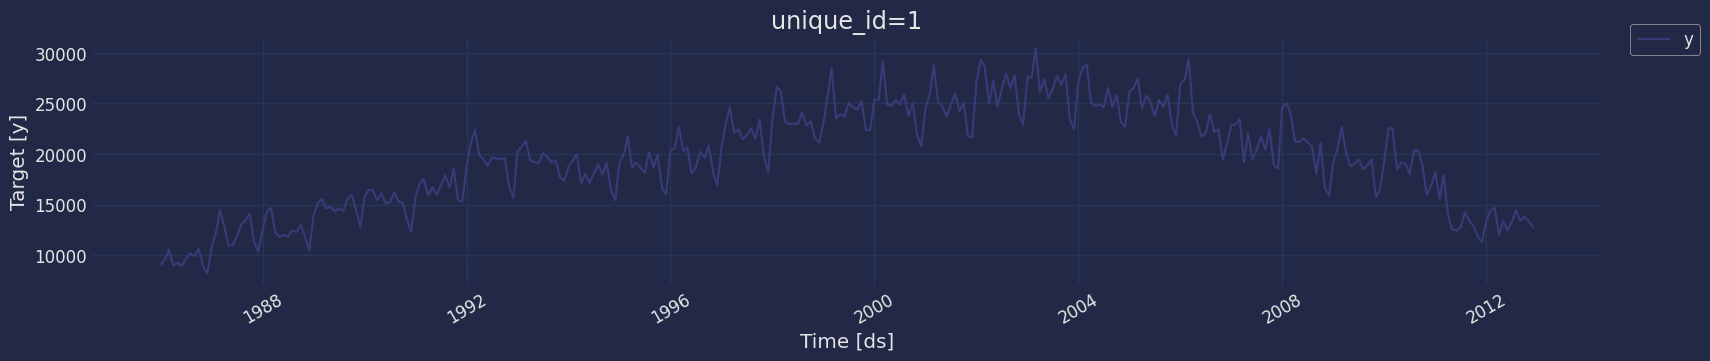

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### The Augmented Dickey-Fuller Test

An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

Let's check if our series that we are analyzing is a stationary series. Let's create a function to check, using the `Dickey Fuller` test

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["y"],'Sales')

Dickey-Fuller test results for columns: Sales
Test Statistic          -1.589903
p-value                  0.488664
No Lags Used            14.000000
                          ...    
Critical Value (1%)     -3.451691
Critical Value (5%)     -2.870939
Critical Value (10%)    -2.571778
Length: 7, dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary


In the previous result we can see that the `Augmented_Dickey_Fuller` test gives us a `p-value` of 0.488664, which tells us that the null hypothesis cannot be rejected, and on the other hand the data of our series are not stationary.

We need to differentiate our time series, in order to convert the data to stationary.

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["y"].diff().dropna(),"Sales")

Dickey-Fuller test results for columns: Sales
Test Statistic          -4.310935
p-value                  0.000425
No Lags Used            17.000000
                          ...    
Critical Value (1%)     -3.451974
Critical Value (5%)     -2.871063
Critical Value (10%)    -2.571844
Length: 7, dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


By applying a differential, our time series now is stationary.

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis plot\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

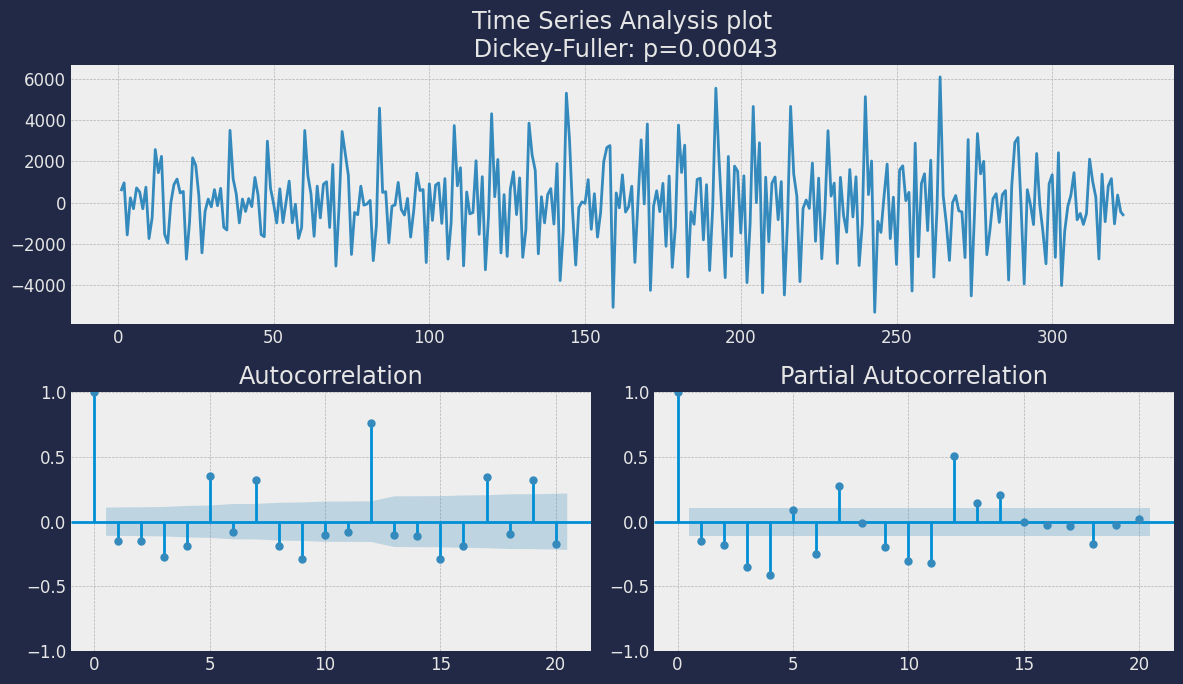

In [ ]:
tsplot(df["y"].diff().dropna(), lags=20);

As you can see, based on the blue background shaded area of the graph, the PACF shows the first, second, third, fourth, sixth, seventh, ninth, and tenth etc. delay outside the shaded area. This means that it would be interesting to also include these lags in the AR model.

### How many lags should we include?
Now, the **big question in time series analysis is always how many lags to include**. This is called the order of the time series. The notation is AR(1) for order 1 and AR(p) for order p.

The order is up to you. Theoretically speaking, you can base your order on the PACF chart. Theory tells you to take the number of lags before you get an autocorrelation of 0. All other lags should be 0.

In theory, you often see great charts where the first peak is very high and the rest equal zero. In those cases, the choice is easy: you are working with a very “pure” example of AR(1). Another common case is when your autocorrelation starts high and slowly decreases to zero. In this case, you should use all delays where the PACF is not yet zero.

However, in practice, it is not always that simple. Remember the famous saying *"all models are wrong, but some are useful"*. It is very rare to find cases that fit an AR model perfectly. In general, the autoregression process can help explain part of the variation of a variable, but not all.

In practice, you will try to select the number of lags that gives your model the best predictive performance. The best predictive performance is often not defined by looking at autocorrelation plots: those plots give you a theoretical estimate. However, predictive performance is best defined by model evaluation and benchmarking, using the techniques you have seen in Module 2. Later in this module, we will see how to use model evaluation to choose a performance order for the AR model. But before we get into that, it's time to dig into the exact definition of the AR model.

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `AutoRegressive` model
2. Data to test our model

For the test data we will use the last 12 months to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2011-12-01']
test = df[df.ds>'2011-12-01']

In [ ]:
train.shape, test.shape

((312, 3), (12, 3))

Now let's plot the training data and the test data.

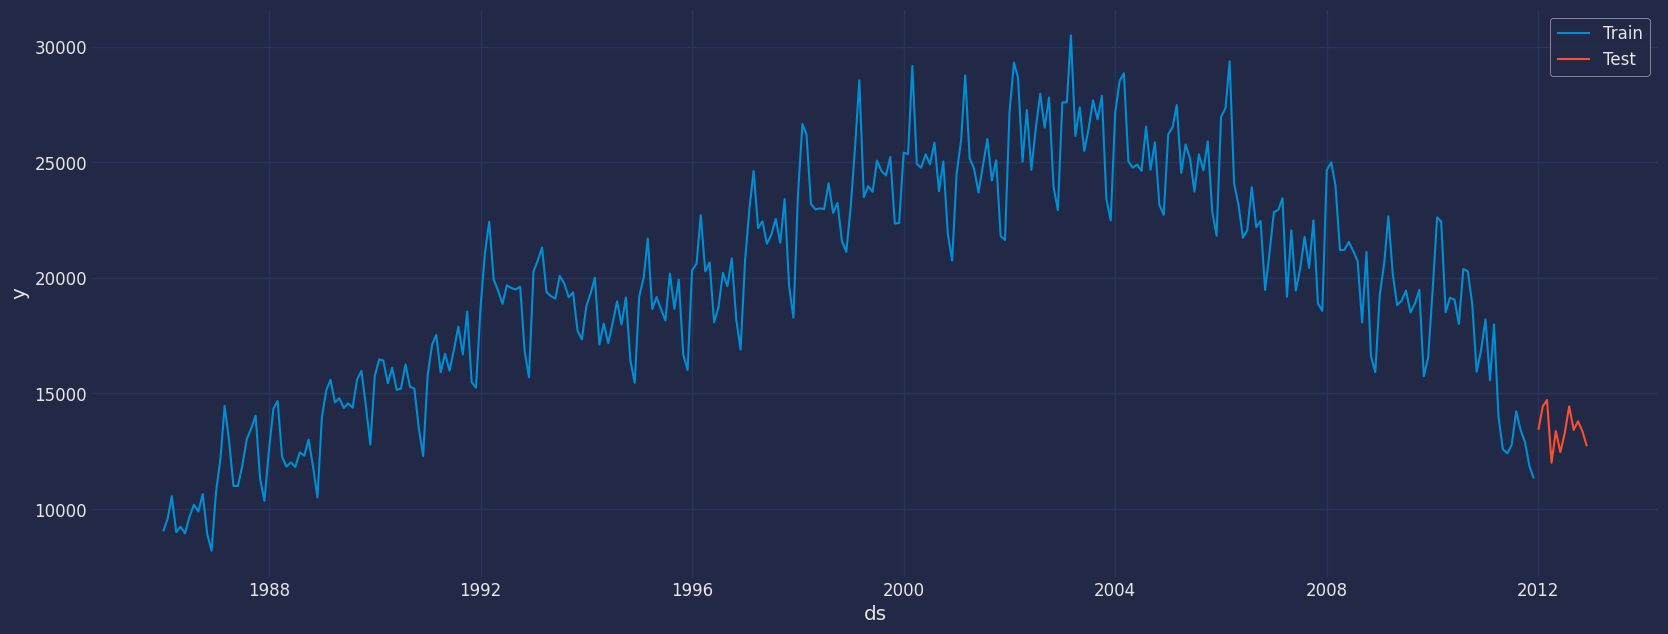

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

# Implementation of AutoRegressive with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoRegressive

### Instantiating Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful.season_length.

**Method 1:** We use the lags parameter in an integer format, that is, we put the lags we want to evaluate in the model.

In [ ]:
season_length = 12 # Monthly data
horizon = len(test) # number of predictions biasadj=True, include_drift=True,

models2 = [AutoRegressive(lags=[14], include_mean=True)]

**Method 2:** We use the lags parameter in a list format, that is, we put the lags that we want to evaluate in the model in the form of a list as shown below.

In [ ]:
season_length = 12 # Monthly data
horizon = len(test) # number of predictions

models = [AutoRegressive(lags=[3,4,6,7,9,10,11,12,13,14], include_mean=True)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='MS')

### Fit Model

In [ ]:
sf.fit(df=train)

StatsForecast(models=[AutoRegressive])

Let's see the results of our Theta model. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
print(result.keys())

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'aicc', 'bic', 'xreg', 'lambda', 'x'])


Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,-11998.537347
1,NaN
2,NaN
...,...
309,-2718.312961
310,-1306.795172
311,-2713.284999


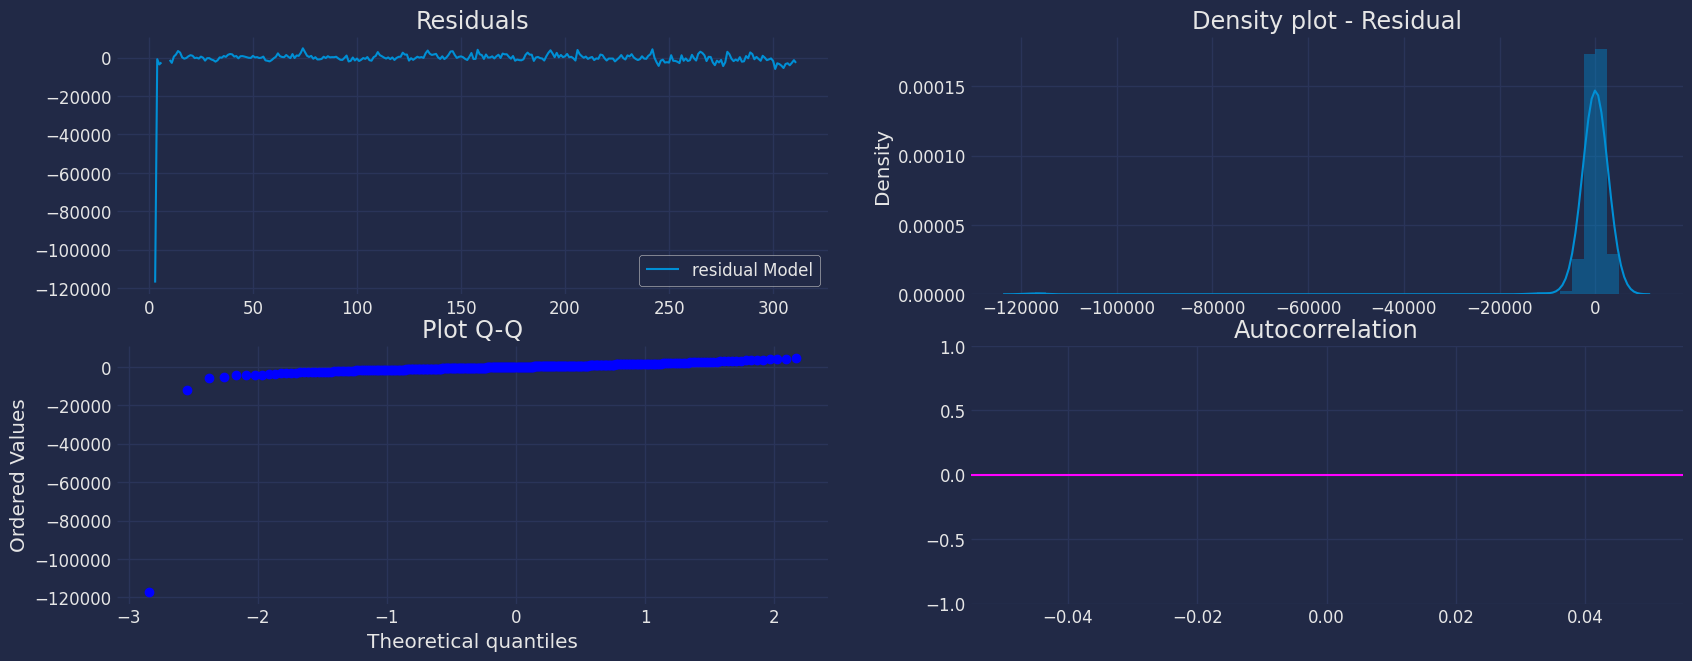

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [ ]:
# Prediction
Y_hat = sf.forecast(df=train, h=horizon, fitted=True)
Y_hat

,unique_id,ds,AutoRegressive
0,1,2012-01-01,15905.582031
1,1,2012-02-01,13597.894531
2,1,2012-03-01,15488.883789
...,...,...,...
9,1,2012-10-01,14087.901367
10,1,2012-11-01,13274.105469
11,1,2012-12-01,12498.226562


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,unique_id,ds,y,AutoRegressive
0,1,1986-01-01,9034.0,21032.537109
1,1,1986-02-01,9596.0,NaN
2,1,1986-03-01,10558.0,NaN
3,1,1986-04-01,9002.0,126172.937500
4,1,1986-05-01,9239.0,10020.040039


Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(df=train, h=horizon, level=[95])

,unique_id,ds,AutoRegressive,AutoRegressive-lo-95,AutoRegressive-hi-95
0,1,2012-01-01,15905.582031,2119.586426,29691.578125
1,1,2012-02-01,13597.894531,-188.101135,27383.890625
2,1,2012-03-01,15488.883789,1702.888062,29274.878906
...,...,...,...,...,...
9,1,2012-10-01,14087.901367,-1050.068359,29225.871094
10,1,2012-11-01,13274.105469,-1886.973145,28435.183594
11,1,2012-12-01,12498.226562,-2675.547607,27672.001953


In [ ]:
# Merge the forecasts with the true values
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,y,unique_id,AutoRegressive
0,2012-01-01,13427,1,15905.582031
1,2012-02-01,14447,1,13597.894531
2,2012-03-01,14717,1,15488.883789
...,...,...,...,...
9,2012-10-01,13795,1,14087.901367
10,2012-11-01,13352,1,13274.105469
11,2012-12-01,12716,1,12498.226562


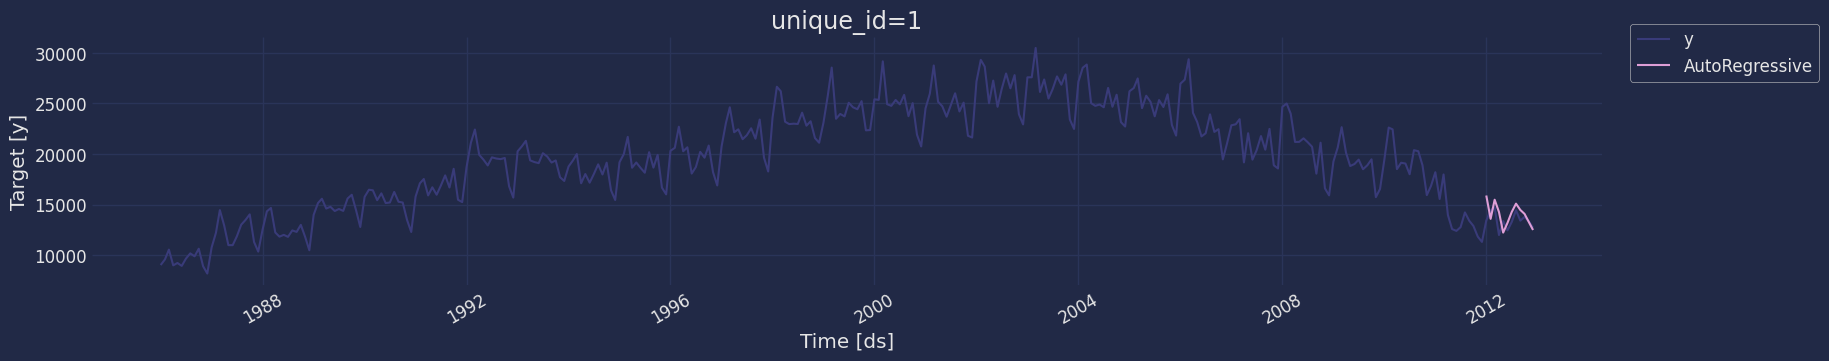

In [ ]:
sf.plot(train, Y_hat1)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon)

,unique_id,ds,AutoRegressive
0,1,2012-01-01,15905.582031
1,1,2012-02-01,13597.894531
2,1,2012-03-01,15488.883789
...,...,...,...
9,1,2012-10-01,14087.901367
10,1,2012-11-01,13274.105469
11,1,2012-12-01,12498.226562


In [ ]:
forecast_df = sf.predict(h=horizon, level=[95])
forecast_df

,unique_id,ds,AutoRegressive,AutoRegressive-lo-95,AutoRegressive-hi-95
0,1,2012-01-01,15905.582031,2119.586426,29691.578125
1,1,2012-02-01,13597.894531,-188.101135,27383.890625
2,1,2012-03-01,15488.883789,1702.888062,29274.878906
...,...,...,...,...,...
9,1,2012-10-01,14087.901367,-1050.068359,29225.871094
10,1,2012-11-01,13274.105469,-1886.973145,28435.183594
11,1,2012-12-01,12498.226562,-2675.547607,27672.001953


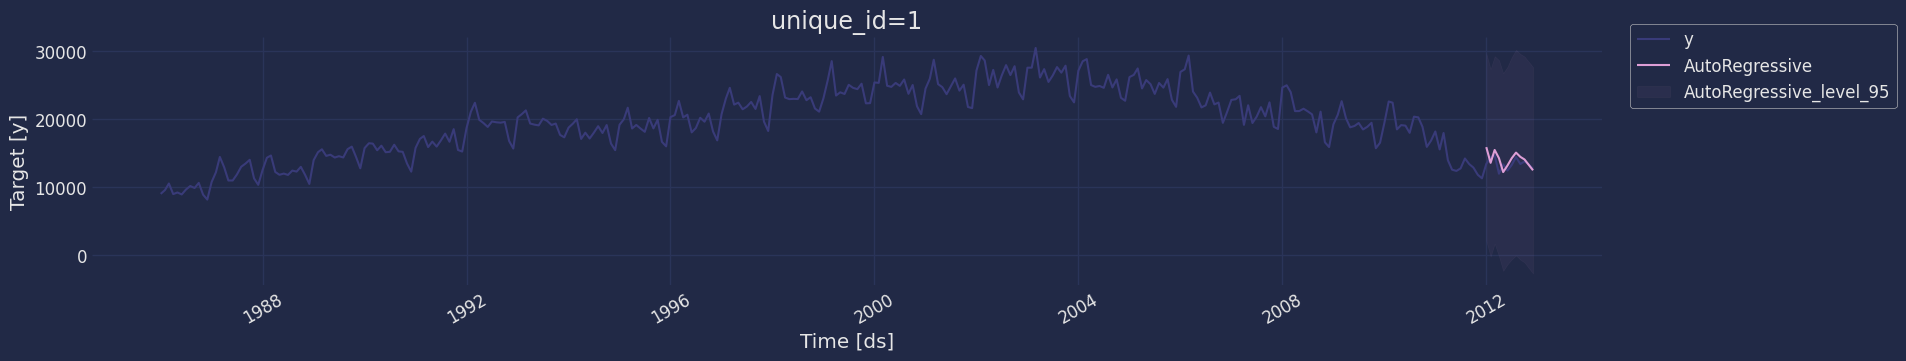

In [ ]:
sf.plot(train, test.merge(forecast_df), level=[95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=6,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` series identifier
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,unique_id,ds,cutoff,y,AutoRegressive
0,1,2009-01-01,2008-12-01,19262.0,24295.837891
1,1,2009-02-01,2008-12-01,20658.0,23993.947266
2,1,2009-03-01,2008-12-01,22660.0,21201.121094
...,...,...,...,...,...
57,1,2011-10-01,2010-12-01,12893.0,19349.708984
58,1,2011-11-01,2010-12-01,11843.0,16899.849609
59,1,2011-12-01,2010-12-01,11321.0,18159.574219


We’ll now plot the forecast for each cutoff period. To make the plots clearer, we’ll rename the actual values in each period.

In [ ]:
from IPython.display import display

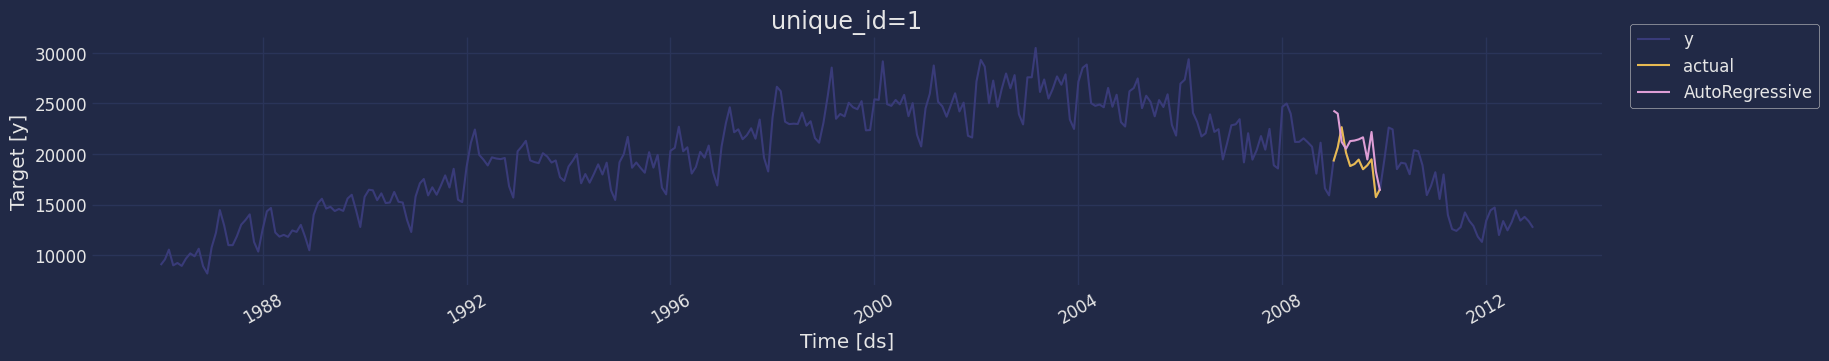

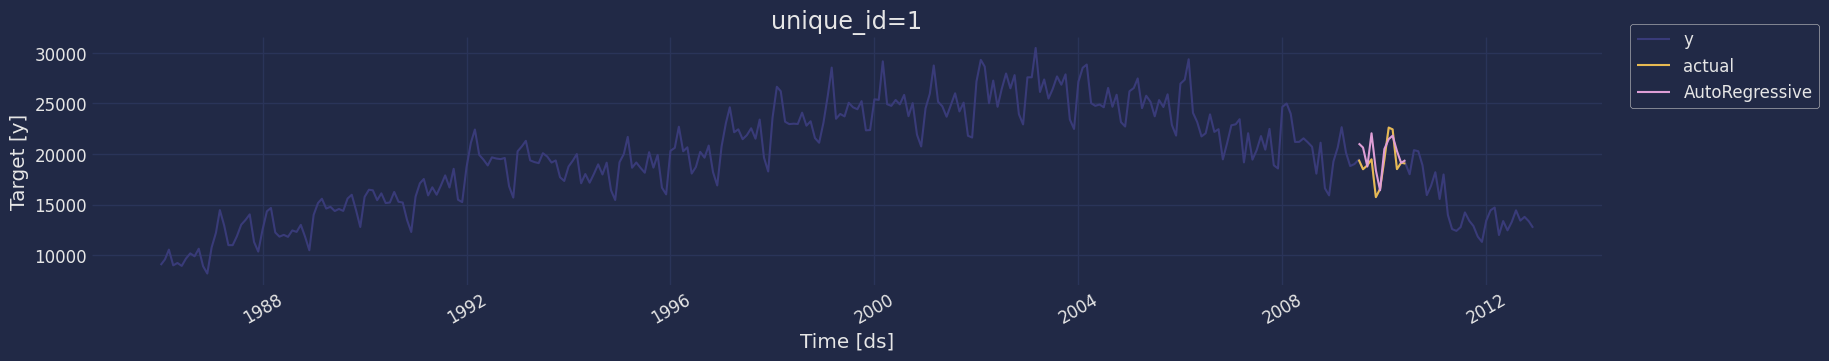

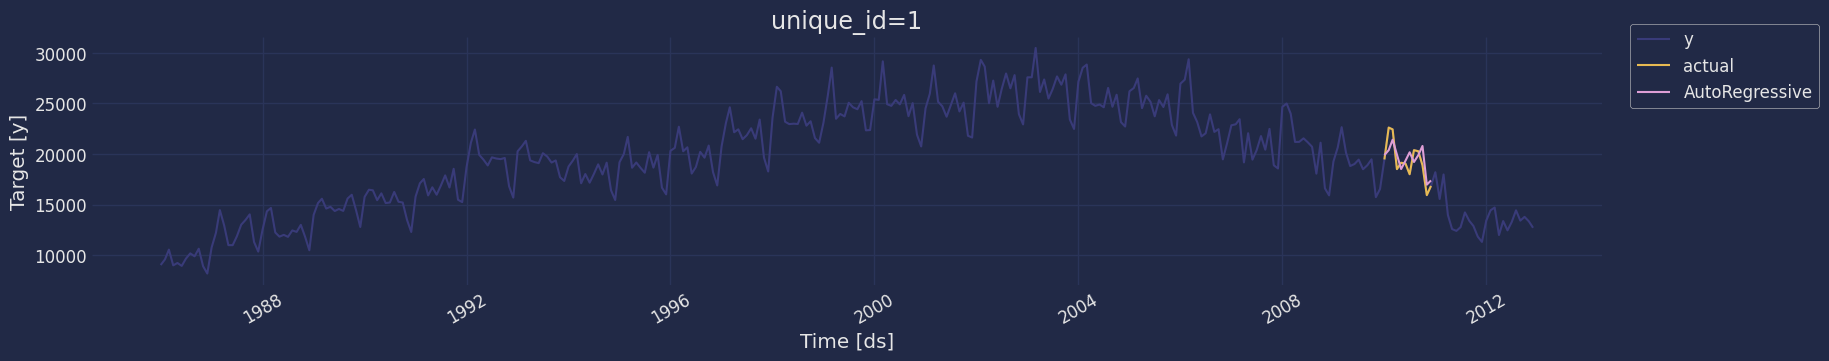

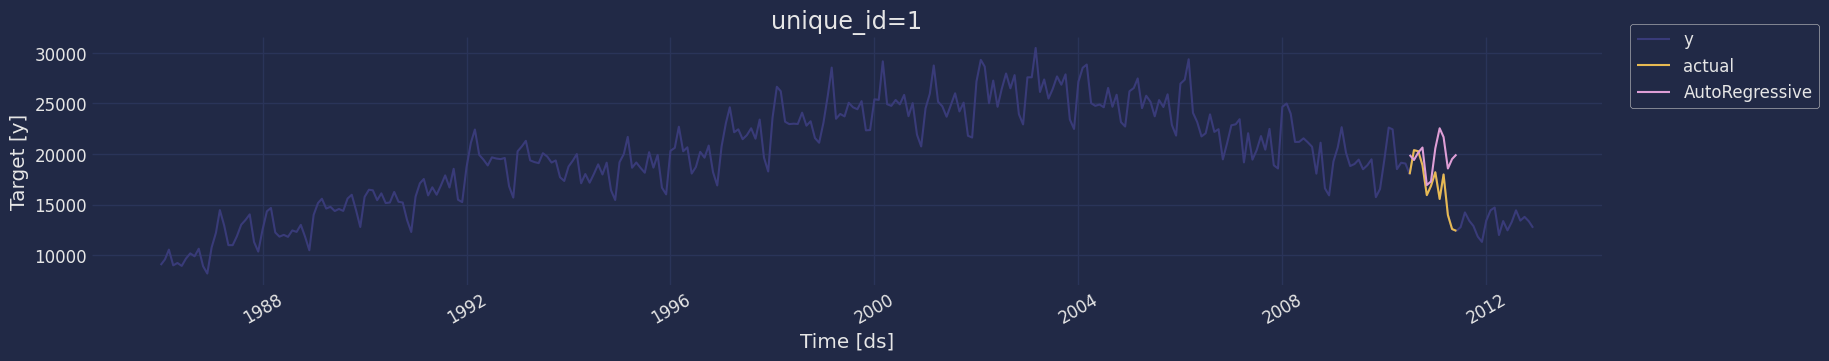

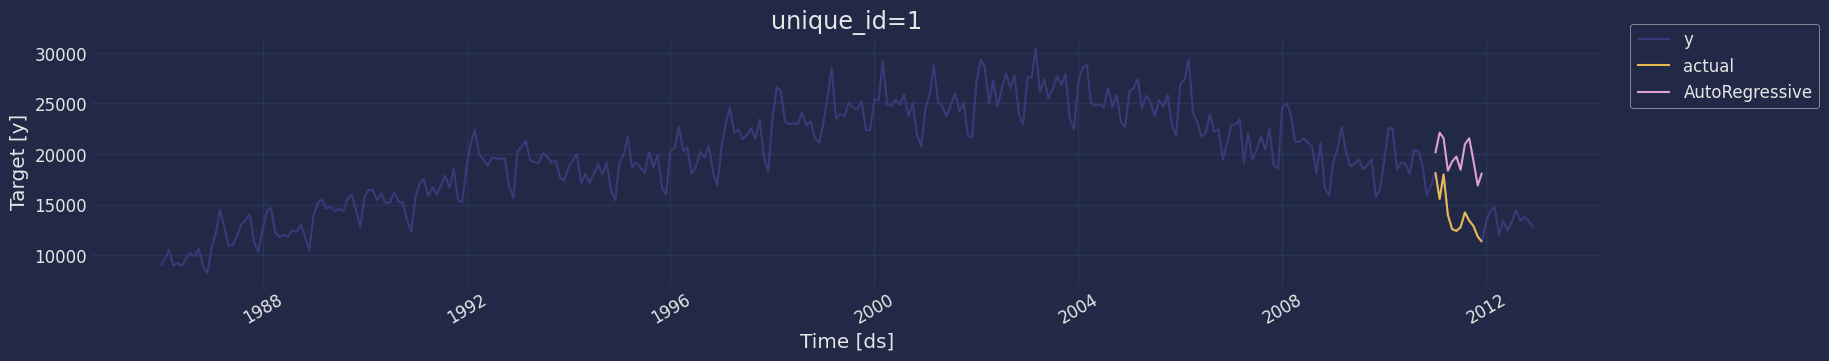

In [ ]:
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values

cutoff = crossvalidation_df['cutoff'].unique()

for k in range(len(cutoff)):
    cv = crossvalidation_df[crossvalidation_df['cutoff'] == cutoff[k]]
    display(StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff']))

## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    test.merge(Y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=season_length), ufl.rmse, ufl.smape],
    train_df=train,
    agg_fn='mean',
)

,metric,AutoRegressive
0,mae,962.023763
1,mape,0.072733
2,mase,0.601808
3,rmse,1195.013050
4,smape,0.034858


## References <a class="anchor" id="references"></a>

1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). “Models for optimising the theta method and their relationship to state space models”. International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243).
3. [Nixtla AutoRegressive API](../../models#class-autoregressive)
4. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
5. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html)
6. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).